In [ ]:
import pandas as pd
import numpy as np
import string
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [1080]:
df = pd.read_csv('../../Downloads/questions.csv').sample(30000, random_state=2)



In [301]:
  contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }


In [302]:
special_characters = {
    "!": "exclamation mark",
    "\"": "double quote",
    "#": "hash",
    "$": "dollar sign",
    "%": "percent",
    "&": "ampersand",
    "'": "apostrophe",
    "(": "left parenthesis",
    ")": "right parenthesis",
    "*": "asterisk",
    "+": "plus sign",
    ",": "comma",
    "-": "hyphen",
    ".": "period",
    "/": "slash",
    ":": "colon",
    ";": "semicolon",
    "<": "less than",
    "=": "equals sign",
    ">": "greater than",
    "?": "question mark",
    "@": "at sign",
    "[": "left square bracket",
    "]": "right square bracket",
    "^": "caret",
    "_": "underscore",
    "`": "backtick",
    "{": "left curly brace",
    "}": "right curly brace",
    "|": "vertical bar",
    "\\": "backslash",
    "~": "tilde",
    "€": "euro sign",
    "£": "pound sign",
    "©": "copyright symbol",
    "®": "registered trademark",
    "™": "trademark",
    "°": "degree symbol",
    "±": "plus-minus sign",
    "→": "right arrow",
    "←": "left arrow",
    "↑": "up arrow",
    "↓": "down arrow",
    "→": "arrow"
}


In [1081]:
def preprocess(question):
    decontracted_q = []
    
    question = str(question).lower().strip()
    ques = question.split()
    for word in ques:
        if word in contractions:
            decontracted_q.append(contractions[word])
        else:
            decontracted_q.append(word)
    
    decontracted = ' '.join(decontracted_q)
    decontracted = decontracted.replace("n't", " not")
    decontracted = decontracted.replace("'re'", " are")
    decontracted = decontracted.replace("'ll'", " will")
    decontracted = decontracted.replace("'ve'", " have")
    # decontracted = decontracted.replace('[math]', '')
    
    decontracted = BeautifulSoup(decontracted)
    removedre = decontracted.get_text()
   
    removedPnc = removePunc(removedre).strip()
    
    removedPnc = removedPnc.replace(',000,000,000 ', 'b ')
    removedPnc = removedPnc.replace(',000,000 ', 'm ')
    removedPnc = removedPnc.replace(',000 ', 'k ')
    removedPnc = re.sub(r'([0-9]+)000000000', r'\1b', removedPnc)
    removedPnc = re.sub(r'([0-9]+)000000', r'\1m', removedPnc)
    removedPnc = re.sub(r'([0-9]+)000', r'\1k', removedPnc)
   
    for char in special_characters:
        if char in removedPnc:
            removedPnc = removedPnc.replace(char, special_characters[char])
    
    return removedPnc.strip()

In [1082]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

/var/folders/xh/dlr59jp10wj5hx57q_rhfy3c0000gn/T/ipykernel_67138/431700833.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  decontracted = BeautifulSoup(decontracted)


In [1083]:
df['q1_len'] = df['question1'].apply(len)
df['q2_len'] = df['question2'].apply(len)

In [1084]:
df['q1_num_words'] = df['question1'].str.split().apply(len)
df['q2_num_words'] = df['question2'].str.split().apply(len)

In [1085]:
def common_words(row):
    q1 = set(row['question1'].split())
    q2 = set(row['question2'].split())
    return len(q1 & q2)

In [1086]:
df['word_common'] = df.apply(common_words, axis=1)

In [1087]:
def total_words(row):
    text1 = row['question1'].split()
    text2 = row['question2'].split()
    return len(text1) + len(text2)

In [1088]:
df['word_total'] = df.apply(total_words, axis=1)

In [1089]:
df

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,11,24
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,7,27
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,2,42
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,0,42
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...
243932,243932,26193,356455,what are some good web scraping tutorials,what are some good web scraping programs,1,41,40,7,7,6,14
91980,91980,154063,154064,can i apply for internet banking in sbi withou...,i have internet banking kit of sbi but it is n...,0,67,60,12,13,4,25
266955,266955,133017,384210,how much he laundry detergent do you use in a ...,can i use regular dawn dishsoap in my dishwash...,0,72,95,14,17,6,31
71112,71112,122427,122428,what is the best way to understand and learn m...,what are some of the best ways to learn math,1,50,44,10,10,5,20


In [1090]:
df['word_share'] = round(df.word_common / df.word_total, 2)

In [1091]:
df

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,11,24,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,7,27,0.26
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,2,42,0.05
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,0,42,0.00
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,14,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243932,243932,26193,356455,what are some good web scraping tutorials,what are some good web scraping programs,1,41,40,7,7,6,14,0.43
91980,91980,154063,154064,can i apply for internet banking in sbi withou...,i have internet banking kit of sbi but it is n...,0,67,60,12,13,4,25,0.16
266955,266955,133017,384210,how much he laundry detergent do you use in a ...,can i use regular dawn dishsoap in my dishwash...,0,72,95,14,17,6,31,0.19
71112,71112,122427,122428,what is the best way to understand and learn m...,what are some of the best ways to learn math,1,50,44,10,10,5,20,0.25


In [1104]:
def fetch_token_features(row):    
    q1 = row['question1'].split()
    q2 = row['question2'].split()
  
    token_features = [0.0]*8

    SAFE_DIV = 0.0001
    stops = stopwords.words("english")
    
    if len(q1) == 0 or len(q2) == 0:
        return token_features

    q1_stops = set([word for word in q1 if word in stops])  
    q2_stops = set([word for word in q2 if word in stops])
  
    
    q1_words = set([word for word in q1 if word not in stops])

    q2_words = set([word for word in q2 if word not in stops])

    token_features[0] = len(q1_words & q2_words) / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = len(q1_words & q2_words) / (max(len(q1_words), len(q2_words)) + SAFE_DIV)

    token_features[2] = len(q1_stops & q2_stops) / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)

    token_features[3] = len(q1_stops & q2_stops) / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    
    token_features[4] = len(set(q1) & set(q2)) / (min(len(set(q1)), len(set(q2))) + SAFE_DIV)
    
    token_features[5] = len(set(q1) & set(q2)) / (max(len(set(q1)), len(set(q2))) + SAFE_DIV)
    
    token_features[6] = int(q1[0] == q2[0])
    
    token_features[7] = int(q1[-1] == q2[-1])

    return token_features
              

In [1105]:
token_features = df.apply(fetch_token_features, axis=1)

In [1106]:
df['cwc_min'] = token_features.apply(lambda x : x[0])
df['cwc_max'] = token_features.apply(lambda x : x[1])
df['csc_min'] = token_features.apply(lambda x : x[2])
df['csc_max'] = token_features.apply(lambda x : x[3])
df['ctc_min'] = token_features.apply(lambda x : x[4])
df['ctc_max'] = token_features.apply(lambda x : x[5])
df['first_word_equal'] = token_features.apply(lambda x : x[6])
df['last_word_equal'] = token_features.apply(lambda x : x[7])

In [1107]:
df[['cwc_min','csc_min']]

,cwc_min,csc_min
398782,0.857131,0.999980
115086,0.666644,0.714276
327711,0.000000,0.399992
367788,0.000000,0.000000
151235,0.749981,0.000000
...,...,...
243932,0.749981,0.999967
91980,0.599988,0.199996
266955,0.499994,0.333328
71112,0.499988,0.599988


In [1108]:
def fetch_length_features(row):
    q1 = row['question1'].split()
    q2 = row['question2'].split()

    length_features = [0.0]*3

    if len(q1) == 0 or len(q2) == 0:
        return length_features

    mean_length = (len(q1) + len(q2)) / 2

    abs_diff = np.abs(len(q1) - len(q2))

    l_substr_ratio = len(set(q1) & set(q2)) / min(len(q1), len(q2))

    length_features[0] = mean_length
    
    length_features[1] = abs_diff
    
    length_features[2] = l_substr_ratio

    return length_features

In [1109]:
length_features = df.apply(fetch_length_features, axis=1)

In [1110]:
df['mean_length'] = length_features.apply(lambda x : x[0])
df['abs_diff'] = length_features.apply(lambda x : x[1])
df['l_substr_ratio'] = length_features.apply(lambda x : x[2])

In [1111]:
from fuzzywuzzy import fuzz

In [1112]:
def fetch_fuzzy_features(row):
    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [1113]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

In [1114]:
df['fuzz_ratio'] = fuzzy_features.apply(lambda x : x[0])
df['fuzz_partial_ratio'] = fuzzy_features.apply(lambda x : x[1])
df['token_sort_ratio'] = fuzzy_features.apply(lambda x : x[2])
df['token_set_ratio'] = fuzzy_features.apply(lambda x : x[3])

In [1115]:
df

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,first_word_equal,last_word_equal,mean_length,abs_diff,l_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,...,0.916659,1,1,12.0,0,0.916667,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,...,0.583328,1,1,13.5,3,0.583333,69,66,65,74
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,...,0.100000,0,0,21.0,8,0.117647,27,30,31,39
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,...,0.000000,0,0,21.0,18,0.000000,27,46,26,31
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.374995,0,1,7.0,4,0.600000,55,70,48,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243932,243932,26193,356455,what are some good web scraping tutorials,what are some good web scraping programs,1,41,40,7,7,...,0.857131,1,0,7.0,0,0.857143,89,85,77,89
91980,91980,154063,154064,can i apply for internet banking in sbi withou...,i have internet banking kit of sbi but it is n...,0,67,60,12,13,...,0.307690,0,0,12.5,1,0.333333,60,62,49,54
266955,266955,133017,384210,how much he laundry detergent do you use in a ...,can i use regular dawn dishsoap in my dishwash...,0,72,95,14,17,...,0.374998,0,0,15.5,3,0.428571,32,38,56,67
71112,71112,122427,122428,what is the best way to understand and learn m...,what are some of the best ways to learn math,1,50,44,10,10,...,0.499995,1,0,10.0,0,0.500000,70,64,72,74


In [1116]:
import seaborn as sns

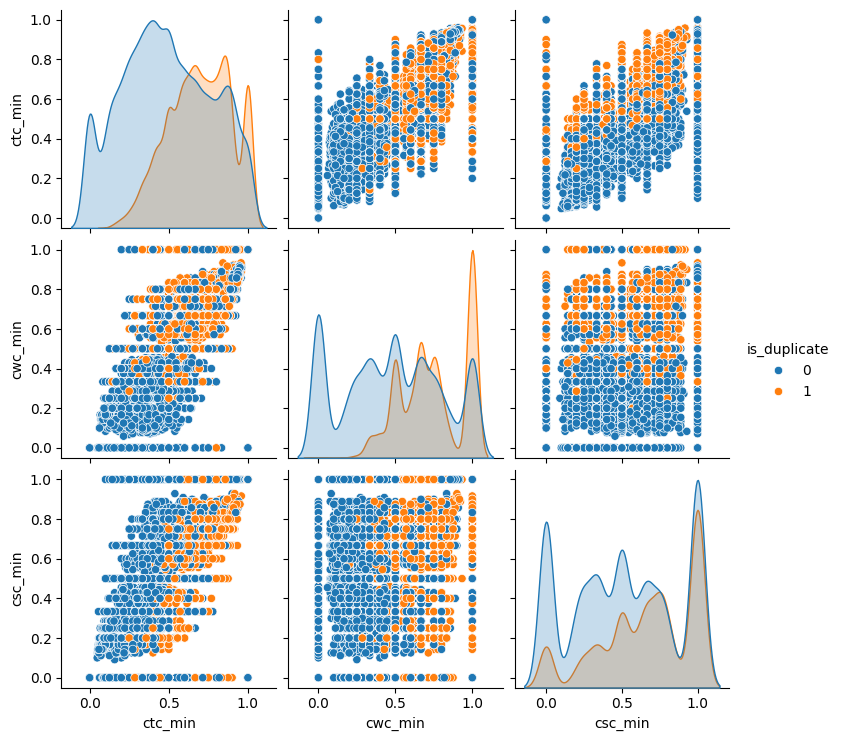

In [1117]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']], hue='is_duplicate')



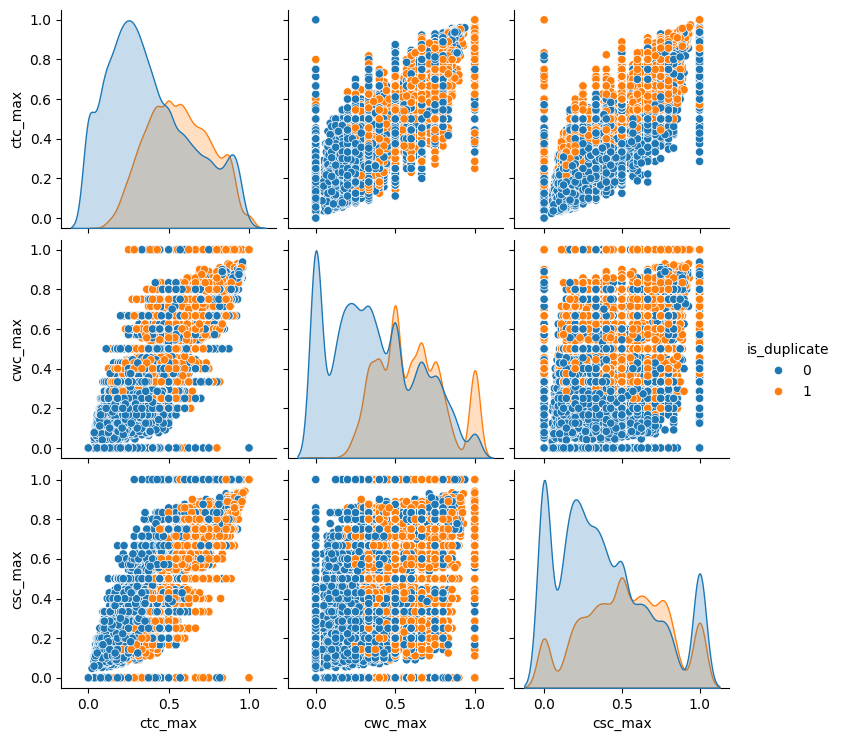

In [1118]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']], hue='is_duplicate')



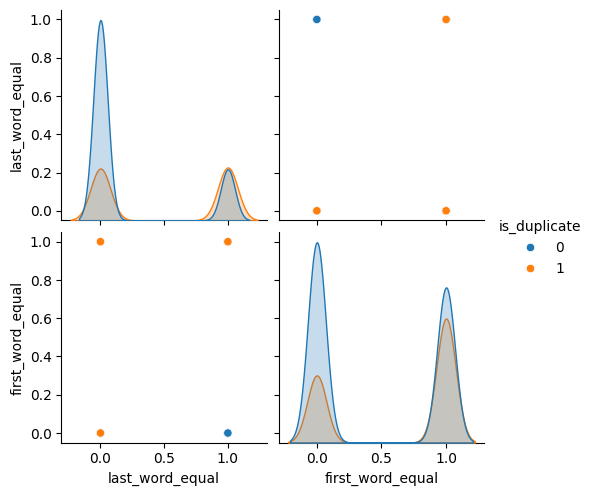

In [1119]:
sns.pairplot(df[['last_word_equal', 'first_word_equal', 'is_duplicate']], hue='is_duplicate')

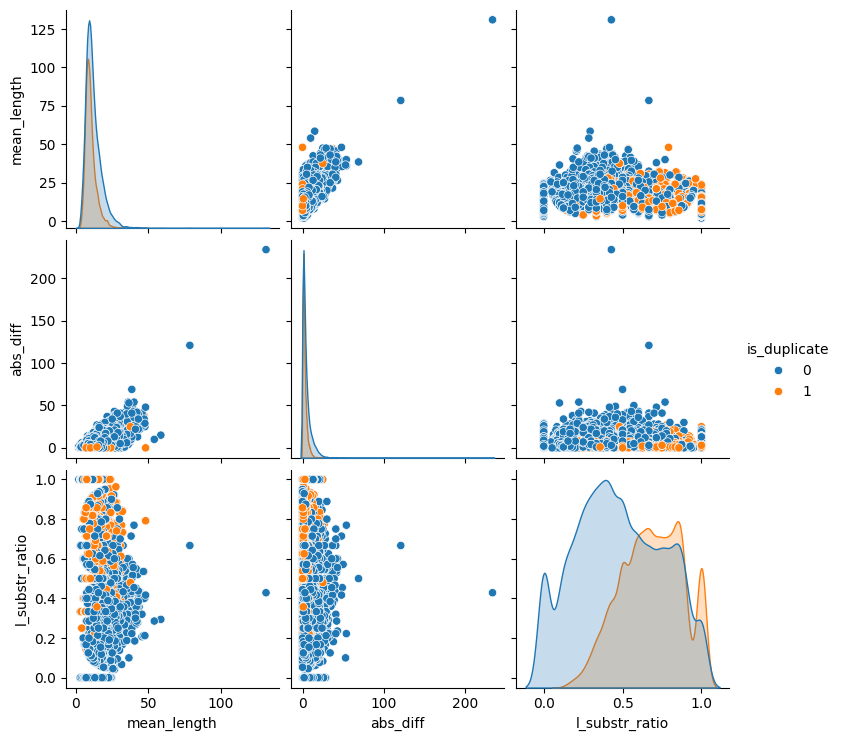

In [1120]:
sns.pairplot(df[['mean_length', 'abs_diff', 'l_substr_ratio', 'is_duplicate']], hue='is_duplicate')

In [1121]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'word_common',
       'word_total', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'first_word_equal', 'last_word_equal',
       'mean_length', 'abs_diff', 'l_substr_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

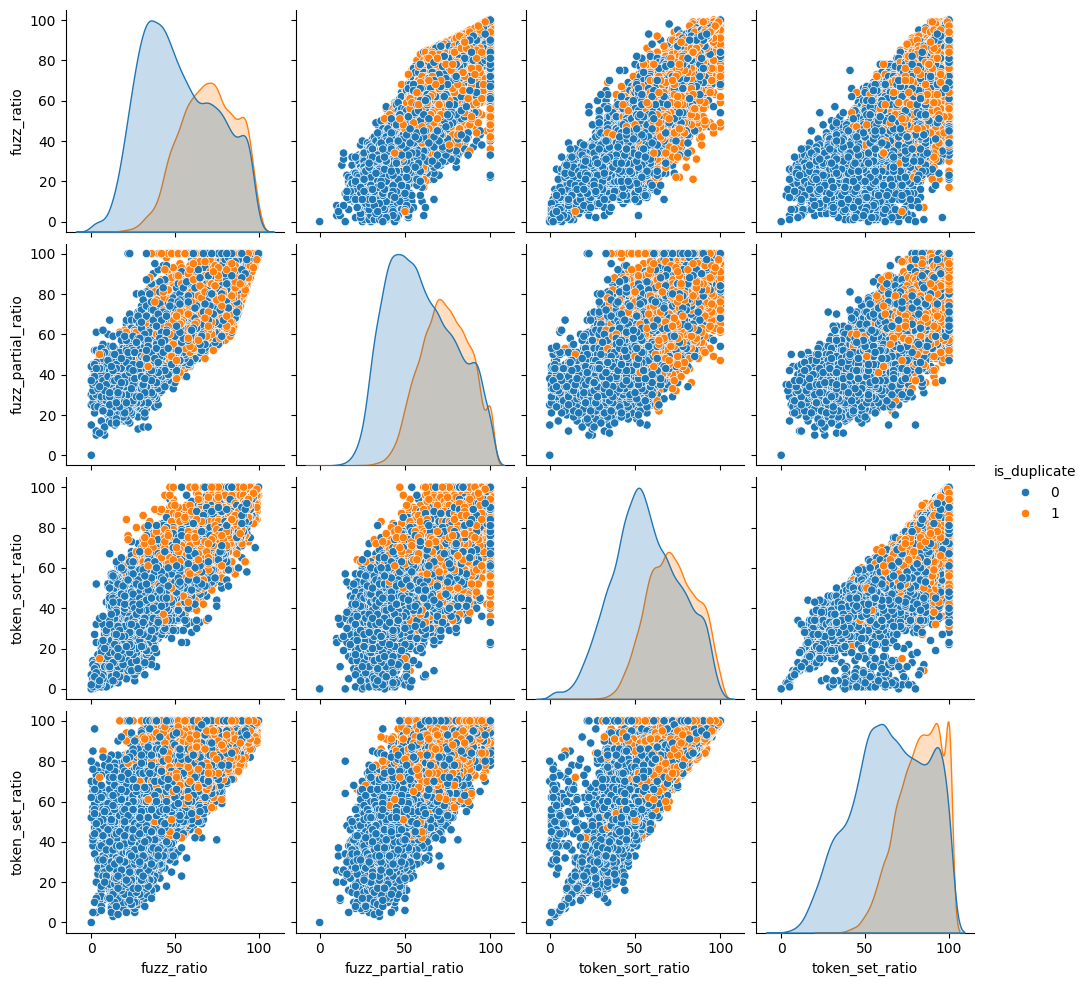

In [1122]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'is_duplicate']], hue='is_duplicate')


In [1123]:
ques_df = df[['question1', 'question2']]

In [1124]:
new_df = df.drop(columns = ['question1', 'question2', 'id', 'qid1', 'qid2'])

In [1125]:
new_df.shape

(30000, 23)

In [1126]:
new_df

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,first_word_equal,last_word_equal,mean_length,abs_diff,l_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,74,75,12,12,11,24,0.46,0.857131,0.857131,...,0.916659,1,1,12.0,0,0.916667,99,99,99,99
115086,0,47,55,12,15,7,27,0.26,0.666644,0.499988,...,0.583328,1,1,13.5,3,0.583333,69,66,65,74
327711,0,101,115,25,17,2,42,0.05,0.000000,0.000000,...,0.100000,0,0,21.0,8,0.117647,27,30,31,39
367788,0,56,143,12,30,0,42,0.00,0.000000,0.000000,...,0.000000,0,0,21.0,18,0.000000,27,46,26,31
151235,0,34,49,5,9,3,14,0.21,0.749981,0.599988,...,0.374995,0,1,7.0,4,0.600000,55,70,48,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243932,1,41,40,7,7,6,14,0.43,0.749981,0.749981,...,0.857131,1,0,7.0,0,0.857143,89,85,77,89
91980,0,67,60,12,13,4,25,0.16,0.599988,0.428565,...,0.307690,0,0,12.5,1,0.333333,60,62,49,54
266955,0,72,95,14,17,6,31,0.19,0.499994,0.499994,...,0.374998,0,0,15.5,3,0.428571,32,38,56,67
71112,1,50,44,10,10,5,20,0.25,0.499988,0.399992,...,0.499995,1,0,10.0,0,0.500000,70,64,72,74


In [1127]:
cv = CountVectorizer(max_features = 3000)

In [1128]:
ques1 = ques_df['question1'].tolist() + ques_df['question2'].tolist()

In [1129]:
q1, q2 = np.vsplit(cv.fit_transform(ques1).toarray(), 2)

In [1130]:
temp_df = pd.concat([pd.DataFrame(q1, index=ques_df.index), 
                     pd.DataFrame(q2, index=ques_df.index)], axis=1)


In [1131]:
final_df = pd.concat([new_df, temp_df], axis=1)

In [1132]:
final_df.shape

(30000, 6023)

In [1133]:
X_train, X_test, y_train, y_test = train_test_split(final_df.iloc[:, 1:], 
                                                    final_df.iloc[:, :1], 
                                                    test_size=0.2, 
                                                    random_state=42)


In [1154]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [1179]:
y_train = y_train.values.ravel()

In [1180]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.783

In [1161]:
X_train

,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
16886,84.0,70.0,16.0,13.0,10.0,29.0,0.34,0.833319,0.714276,0.999980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
349845,52.0,45.0,8.0,8.0,6.0,16.0,0.38,0.599988,0.599988,0.999967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331239,51.0,44.0,10.0,10.0,6.0,20.0,0.30,0.666644,0.499988,0.666656,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
350540,34.0,27.0,6.0,4.0,4.0,10.0,0.40,0.999950,0.999950,0.999950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139497,21.0,30.0,4.0,5.0,4.0,9.0,0.44,0.999950,0.666644,0.999950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193120,60.0,60.0,12.0,12.0,12.0,24.0,0.50,0.999983,0.999983,0.999983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308620,34.0,48.0,7.0,8.0,4.0,15.0,0.27,0.999967,0.749981,0.249994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105504,37.0,21.0,7.0,5.0,3.0,12.0,0.25,0.499975,0.333322,0.666644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103393,74.0,143.0,17.0,30.0,14.0,47.0,0.30,0.714276,0.454541,0.899991,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
X_train = X_train.values
X_test = X_test.values

In [1173]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7908333333333334